In [380]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import label, regionprops

In [381]:
def uv2xyz(uv,imW,imH):
    tetha = - (uv[:,1] - imH / 2) * np.pi / imH
    phi = (uv[:,0] - imW / 2) * 2 * np.pi / imW
    xyz = np.array([np.sin(phi) * np.cos(tetha),np.cos(tetha) * np.cos(phi),np.sin(tetha)])
    return xyz.T

In [382]:
def cmap2corners(cmap):
    # when corners appear at the image borders, the heatmap can extend to both sides of the image (left and right) 
    # By concatenating 3 times the corner map, we are sure that we detect the maximum once, avoiding repeated corners
    cmap = cmap/255.
    cmap_ = np.hstack((cmap,cmap,cmap))
    cmap_prob = cmap_.copy()

    th = 0.1
    cmap_[cmap_<th] = 0
    cmap_[cmap_>th] = 1
    label_cmap = label(cmap_)
    regions = regionprops(label_cmap, cmap_prob)

    cor_uv = []
    for props in regions:
        y0, x0 = props.weighted_centroid 
        if x0 > (pano_W-1) and x0 < (pano_W*2+1):
            cor_uv.append([x0-pano_W,y0])

    cor_uv = np.array(cor_uv)
    
    #order from left to right
    sorted_cor_uv = sorted(cor_uv, key=lambda x: x[0])
    sorted_cor_uv = np.array([arr.tolist() for arr in sorted_cor_uv])

    return sorted_cor_uv

In [383]:
# load image
img_path = "/path_to_image_rgb/"
img_name = "pano_ajjyfrdhqyllgb.jpg"
img = Image.open(img_path+img_name)
img = np.array(img)
pano_H = img.shape[0]
pano_W = img.shape[1]

# load corner map
cmap_path = "/path_to_cmap/"
cmap_name = "pano_ajjyfrdhqyllgb_CM.jpg"
cmap = Image.open(cmap_path+cmap_name)
cmap = np.array(cmap)

In [384]:
# get 2D corners from corner map
cor_uv = cmap2corners(cmap)
print(cor_uv)

[[206.48770834 391.31334838]
 [206.48954628 163.00322109]
 [434.97544109 335.5       ]
 [434.98310881 205.99263024]
 [538.39579396 203.08884089]
 [538.40197881 339.40523892]
 [614.8949803  112.87782917]
 [614.91174143 437.5912082 ]
 [718.98772411 185.99750727]
 [718.99912591 363.00090531]
 [809.97327568 366.4982042 ]
 [809.98413724 184.02001084]]


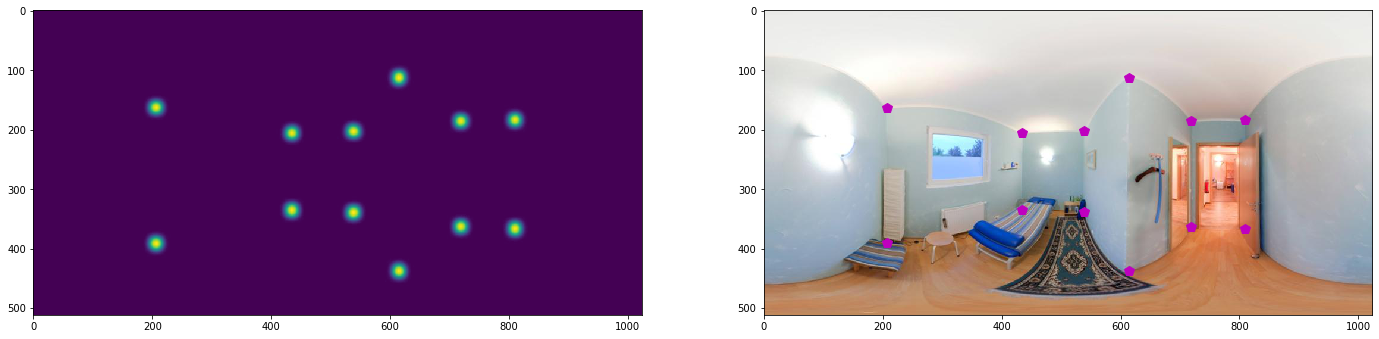

In [385]:
# show corner map and image with 2D corners
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24,8))
plt.sca(axs[0])
plt.imshow(cmap)
plt.sca(axs[1]) 
plt.plot(cor_uv[:,0], cor_uv[:,1], 'mp', markersize=10)
plt.imshow(img)
plt.show()

In [386]:
# project pixel coordinates onto the unit sphere
cor_xyz = uv2xyz(cor_uv,pano_W,pano_H)

# separate ceiling and floor corners according to the horizon line (if image is aligned, the horizon line is centered)
ceil_xyz = cor_xyz[cor_xyz[:,2]>0,:]
floor_xyz = cor_xyz[cor_xyz[:,2]<0,:]

In [387]:
# floor plane - assumption: camera at 1.7m
d_floor = 1.7
t_floor = -d_floor/floor_xyz[:,2]
floor_3D = np.expand_dims(t_floor, axis=1) * floor_xyz

In [388]:
# ceiling plane - assumption: ceiling plane and floor plane are parallel
t_ceil = floor_3D[:,0]/ceil_xyz[:,0]
ceil_3D = np.expand_dims(t_ceil, axis=1) * ceil_xyz
d_ceil = np.mean(t_ceil*ceil_xyz[:,2])
ceil_3D[:,2] = d_ceil

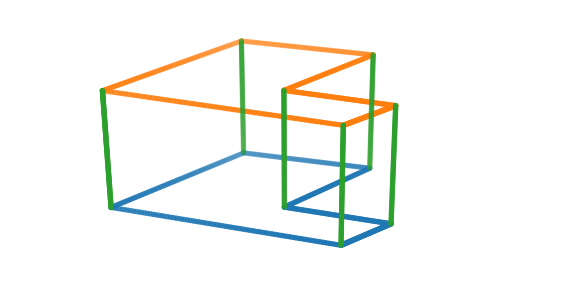

In [389]:
# sample points to visualize 3D layout
n = 80

floor_3D = np.vstack((floor_3D, floor_3D[0,:]))
ceil_3D = np.vstack((ceil_3D, ceil_3D[0,:]))

floor_structure = np.array([[np.linspace(floor_3D[p,0],floor_3D[p+1,0],n), \
                   np.linspace(floor_3D[p,1],floor_3D[p+1,1],n), \
                   np.linspace(floor_3D[p,2],floor_3D[p+1,2],n)] for p in range(len(floor_3D)-1)])
ceil_structure = np.array([[np.linspace(ceil_3D[p,0],ceil_3D[p+1,0],n), \
                   np.linspace(ceil_3D[p,1],ceil_3D[p+1,1],n), \
                   np.linspace(ceil_3D[p,2],ceil_3D[p+1,2],n)] for p in range(len(ceil_3D)-1)])
walls_structure = np.array([[np.linspace(floor_3D[p,0],ceil_3D[p,0],n), \
                   np.linspace(floor_3D[p,1],ceil_3D[p,1],n), \
                   np.linspace(floor_3D[p,2],ceil_3D[p,2],n)] for p in range(len(ceil_3D))])

# display the 3D layout
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(floor_structure[:,0,:], floor_structure[:,1,:], floor_structure[:,2,:])
ax.scatter(ceil_structure[:,0,:], ceil_structure[:,1,:], ceil_structure[:,2,:])
ax.scatter(walls_structure[:,0,:], walls_structure[:,1,:], walls_structure[:,2,:])
ax._axis3don = False
plt.show()